<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Building a groundwater model from scratch

This notebook shows how to build a basic model from scratch using `nlmod`.

In [1]:
import flopy as fp
import matplotlib.pyplot as plt
import nlmod
import numpy as np
import pandas as pd

In [2]:
nlmod.util.get_color_logger("INFO");

## Download MODFLOW-binaries
To run MODFLOW, we need to download the MODFLOW-excecutables. We do this with the following code:

In [3]:
if not nlmod.util.check_presence_mfbinaries():
    nlmod.util.download_mfbinaries()

## Model parameters

In [4]:
extent = [-500, 500, -500, 500]

top = 0.0
botm = [-10, -15, -30]

kh = [10, 0.1, 20]
kv = [0.5 * k for k in kh]

dx = 10.0
dy = 10.0

### Create model dataset

In [5]:
ds = nlmod.get_ds(
    extent,
    delr=dx,
    delc=dy,
    top=top,
    botm=botm,
    kh=kh,
    kv=kv,
    model_ws="./scratch_model",
    model_name="from_scratch",
)
ds

INFO:nlmod.dims.base:resample layer model data to structured modelgrid


<xarray.Dataset>
Dimensions:  (y: 100, x: 100, layer: 3)
Coordinates:
  * layer    (layer) int64 1 2 3
  * x        (x) float64 -495.0 -485.0 -475.0 -465.0 ... 465.0 475.0 485.0 495.0
  * y        (y) float64 495.0 485.0 475.0 465.0 ... -465.0 -475.0 -485.0 -495.0
Data variables:
    top      (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    botm     (layer, y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -30.0 -30.0 -30.0
    kh       (layer, y, x) float64 10.0 10.0 10.0 10.0 ... 20.0 20.0 20.0 20.0
    kv       (layer, y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 10.0 10.0 10.0 10.0
    area     (y, x) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0 100.0
    idomain  (layer, y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    extent:                    [-500, 500, -500, 500]
    gridtype:                  structured
    delr:                      10.0
    delc:                      10.0
    model_name:                from_scratch
    mfversion:                 mf6
    model_dataset_created_on:  20230509_17:25:09
    exe_name:                  /home/david/Github/nlmod/nlmod/bin/mf6
    model_ws:                  ./scratch_model
    figdir:                    ./scratch_model/figure
    cachedir:                  ./scratch_model/cache
    transport:                 0

### Set time discretisation

In [6]:
ds = nlmod.time.set_ds_time(ds, time=pd.Timestamp.today())

### Start building model

In [7]:
sim = nlmod.sim.sim(ds)
tdis = nlmod.sim.tdis(ds, sim)
ims = nlmod.sim.ims(sim, complexity="SIMPLE")
gwf = nlmod.gwf.gwf(ds, sim)
dis = nlmod.gwf.dis(ds, gwf)
npf = nlmod.gwf.npf(ds, gwf)
ic = nlmod.gwf.ic(ds, gwf, starting_head=1.0)
oc = nlmod.gwf.oc(ds, gwf, save_head=True)

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:creating modflow OC


### Add wells

In [8]:
wells = pd.DataFrame(columns=["x", "y", "top", "botm", "Q"], index=range(2))
wells.index.name = "well no."
wells.loc[0] = 100, -50, -5, -10, -100.0
wells.loc[1] = 200, 150, -20, -30, -300.0
wells

,x,y,top,botm,Q
well no.,,,,,
0,100,-50,-5,-10,-100.0
1,200,150,-20,-30,-300.0


In [9]:
wel = nlmod.gwf.wells.wel_from_df(wells, gwf)

Adding WELs: 100%|██████████| 2/2 [00:00<00:00, 694.31it/s]


### Add river

In [10]:
xyriv = [
    (250, -500),
    (300, -300),
    (275, 0),
    (200, 250),
    (175, 500),
]

riv_layer = 0  # add to first layer

bed_resistance = 0.1  # days
riv_cond = dx * dy / bed_resistance  # conductance
riv_stage = 1.0  # m NAP
riv_botm = -3.0  # m NAP

In [11]:
riv_data = nlmod.gwf.surface_water.rivdata_from_xylist(
    gwf, xyriv, riv_layer, riv_stage, riv_cond, riv_botm
)

riv = fp.mf6.ModflowGwfriv(gwf, stress_period_data={0: riv_data})

### Write and run Simulation

In [12]:
nlmod.sim.write_and_run(sim, ds, silent=True)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
INFO:nlmod.sim.sim:run model


### Load heads

In [13]:
head = nlmod.gwf.get_heads_da(ds)

### Plot heads

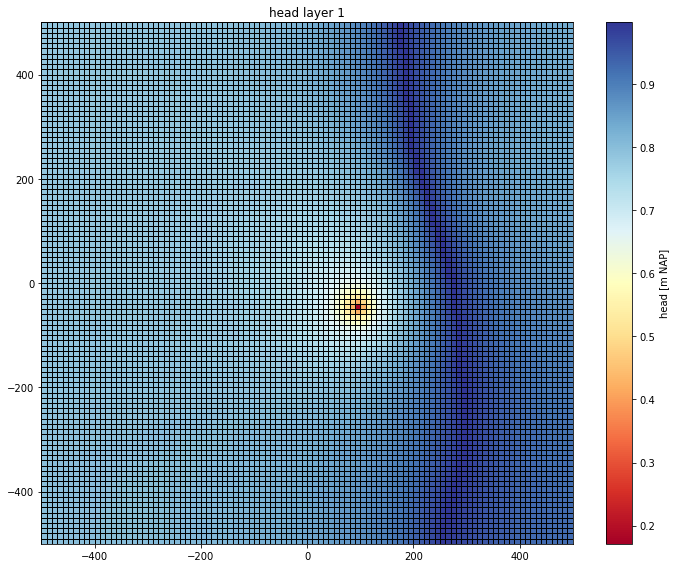

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pc = nlmod.plot.data_array(
    head.sel(layer=1).isel(time=0),
    ds=ds,
    cmap="RdYlBu",
    ax=ax,
    edgecolor="k",
)
ax.axis(extent)
cbar = ax.figure.colorbar(pc, shrink=1.0)
cbar.set_label("head [m NAP]")
ax.set_title("head layer 1")
fig.tight_layout()

### Plot heads in all layers

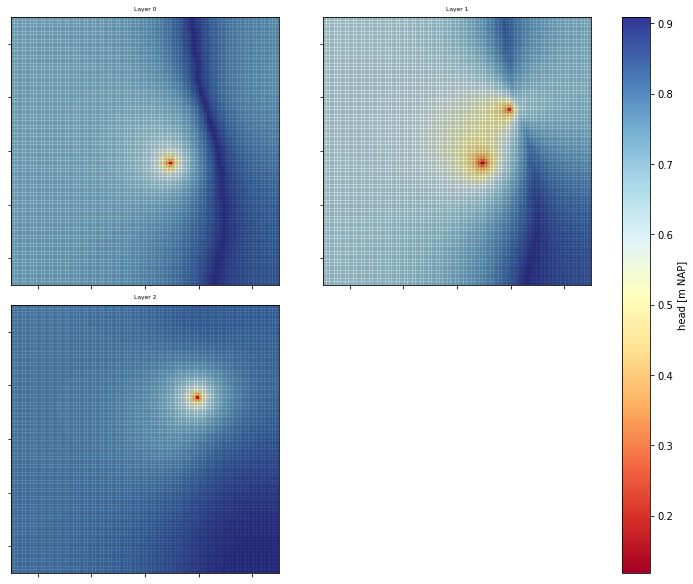

In [15]:
fig, axes = nlmod.plot.facet_plot(
    gwf,
    head,
    lbl="head [m NAP]",
    plot_dim="layer",
    period=0,
    cmap="RdYlBu",
    plot_bc={"WEL": {}},
    plot_grid=True,
)